In [1]:
import pandas as pd
from glob import glob
from tqdm import tqdm
from yellowbrick.regressor import ResidualsPlot
from sklearn.linear_model import LassoCV
import numpy as np
import os
import xgboost as xgb
from sklearn.metrics import mean_squared_error as MSE 
import seaborn as sns

rng = np.random.default_rng(None)

In [2]:
#dataset = dataset_from_files()
dataset = pd.read_parquet('sim_dataset.parquet')
dataset = dataset.fillna(0)
dataset['sim_id'] = dataset['simulation']

In [3]:
#values = ['removed', 'susceptible', 'exposed', 'infected', 'hospitalized']

#total = dataset[values].sum(axis=1)
#for c in values:
#    dataset[c] = dataset[c] / total

In [4]:
shifts = []
for i in range(1,5):
    shifted = dataset.groupby('simulation').shift(i)
    shifted['week'] = shifted['week'] + i
    shifted = shifted.reset_index(drop=True)
    shifted.columns = pd.Series(shifted.columns).apply(lambda x: x if x in ['week', 'sim_id'] else x+'_'+str(i))
    shifts.append(shifted)

In [5]:
df = dataset.copy()
for shift in shifts:
    df = pd.merge(df, shift, on=['sim_id', 'week'])

In [6]:
unique_ids = df.sim_id.unique()
train = rng.choice(unique_ids, size=int(len(unique_ids)*0.6), replace=False)
test = [uid for uid in unique_ids if uid not in train]

train_df = df[df['sim_id'].isin(train)].drop(columns=['simulation', 'sim_id'])
test_df = df[df['sim_id'].isin(test)].drop(columns=['simulation', 'sim_id'])

train_df.shape, test_df.shape

((12672, 31), (8448, 31))

In [7]:
action_cols = [c for c in train_df.columns if 'action' in c]
train_df = pd.get_dummies(train_df, columns=action_cols)
test_df = pd.get_dummies(test_df, columns=action_cols)

In [8]:
X_train = train_df.drop(columns=['removed', 'susceptible', 'exposed', 'infected', 'hospitalized'])
#X_train = train_df.drop(columns=['hospitalized'])
y_train = train_df['hospitalized']

X_test = test_df.drop(columns=['removed', 'susceptible', 'exposed', 'infected', 'hospitalized'])
y_test = test_df['hospitalized']


In [9]:
reg = LassoCV(cv=5, random_state=0, max_iter=10000).fit(X_train, y_train)
reg.score(X_train, y_train)

/home/yamba/anaconda3/envs/cmdp/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 72528.26554831676, tolerance: 7082.237462428977
  model = cd_fast.enet_coordinate_descent(


0.9821882284842642

In [10]:
pred = reg.predict(X_test)
rmse = np.sqrt(MSE(y_test, pred)) 
print("RMSE : % f" %(rmse)) 

RMSE :  9.807436


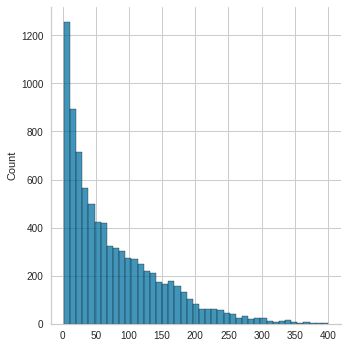

In [11]:
sns.displot(pred)

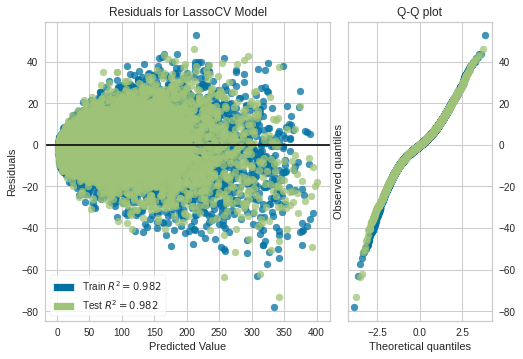

<AxesSubplot:title={'center':'Residuals for LassoCV Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [12]:
visualizer = ResidualsPlot(reg, hist=False, qqplot=True)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

In [13]:
from sklearn.linear_model import LinearRegression

In [14]:
act_cols = [c for c in X_train.columns if 'action' in c]

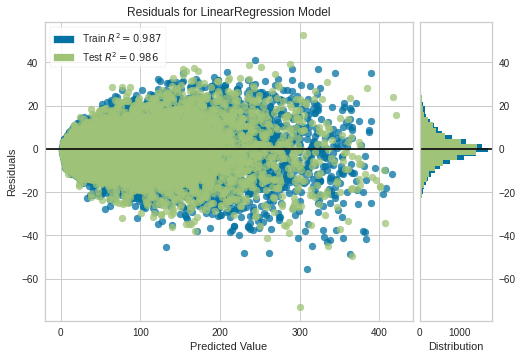

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [15]:
reg = LinearRegression()
act_cols = [c for c in X_train.columns if 'action' in c] + ['week']
X_train_noact = X_train.drop(columns=act_cols)
X_test_noact = X_test.drop(columns=act_cols)

visualizer = ResidualsPlot(reg)

visualizer.fit(X_train_noact, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_noact, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

In [16]:
# Instantiation 
xgb_r = xgb.XGBRegressor(objective ='reg:squarederror') 
  
# Fitting the model 
xgb_r.fit(X_train, y_train) 
  
# Predict the model 
pred = xgb_r.predict(X_test) 
  
# RMSE Computation 
rmse = np.sqrt(MSE(y_test, pred)) 
print("RMSE : % f" %(rmse)) 

RMSE :  9.107788


In [17]:
y_test.mean()

77.10097064393939

In [18]:
from sklearn.metrics import r2_score
r2_score(y_test, pred)

0.9840709922318966

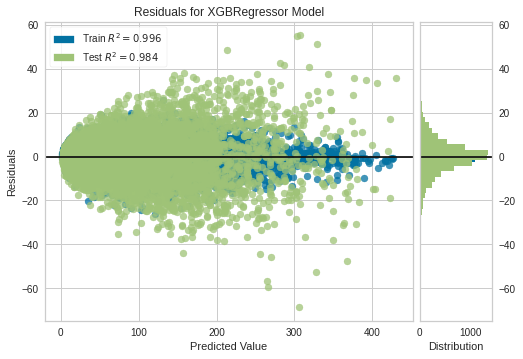

<AxesSubplot:title={'center':'Residuals for XGBRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [19]:
xgb_r = xgb.XGBRegressor(objective ='reg:squarederror') 

visualizer = ResidualsPlot(xgb_r)

visualizer.fit(X_train_noact, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_noact, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

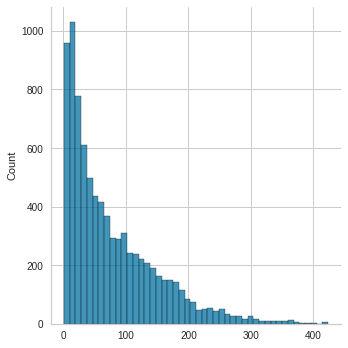

In [20]:
import seaborn as sns
sns.displot(pred)

In [21]:
from sklearn.preprocessing import StandardScaler

In [22]:
scaler = StandardScaler()

In [23]:
scaler = scaler.fit(X_train_noact)

In [24]:
X_sc_train = scaler.transform(X_train_noact)
X_sc_test = scaler.transform(X_test_noact)

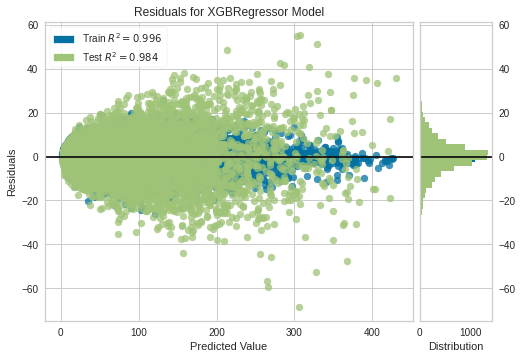

RMSE :  9.211869


In [25]:
xgb_r = xgb.XGBRegressor(objective ='reg:squarederror') 

visualizer = ResidualsPlot(xgb_r)

visualizer.fit(X_sc_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_sc_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

# RMSE Computation 
rmse = np.sqrt(MSE(y_test, visualizer.predict(X_sc_test))) 
print("RMSE : % f" %(rmse))

In [26]:
known_cols = [c for c in X_train.columns
                if 'removed' in c or 'hospitalized' in c]

In [46]:
X_train_known = X_train[known_cols+['week']]
X_test_known = X_test[known_cols+['week']]

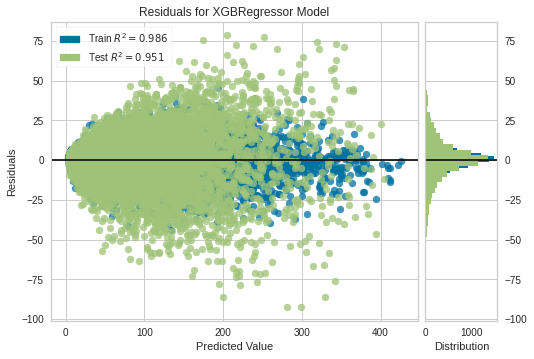

RMSE :  16.037788


In [47]:
xgb_r = xgb.XGBRegressor(objective ='reg:squarederror') 

visualizer = ResidualsPlot(xgb_r)

visualizer.fit(X_train_known, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_known, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

# RMSE Computation 
rmse = np.sqrt(MSE(y_test, visualizer.predict(X_test_known))) 
print("RMSE : % f" %(rmse))

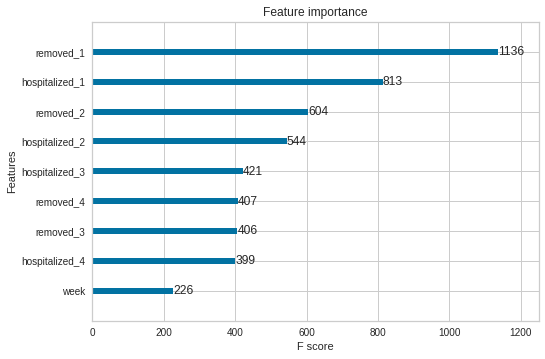

In [48]:
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(visualizer._Booster, max_num_features=20)
pyplot.show()

In [30]:
X_train_known

,removed_1,hospitalized_1,removed_2,hospitalized_2,removed_3,hospitalized_3,removed_4,hospitalized_4
66,95.0,6.0,42.0,4.0,6.0,0.0,0.0,0.0
67,201.0,5.0,95.0,6.0,42.0,4.0,6.0,0.0
68,369.0,9.0,201.0,5.0,95.0,6.0,42.0,4.0
69,694.0,24.0,369.0,9.0,201.0,5.0,95.0,6.0
70,1268.0,40.0,694.0,24.0,369.0,9.0,201.0,5.0
...,...,...,...,...,...,...,...,...
21093,16254.0,219.0,13871.0,213.0,11276.0,159.0,9007.0,137.0
21094,18508.0,199.0,16254.0,219.0,13871.0,213.0,11276.0,159.0
21095,20171.0,134.0,18508.0,199.0,16254.0,219.0,13871.0,213.0
21096,21098.0,83.0,20171.0,134.0,18508.0,199.0,16254.0,219.0


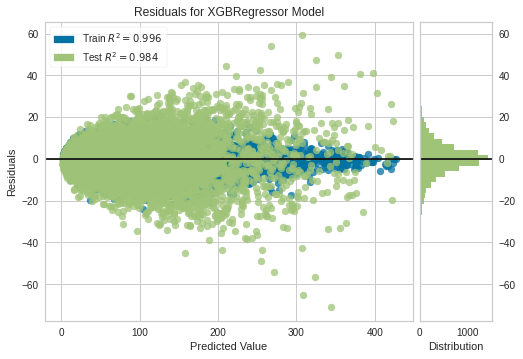

RMSE :  9.107788


In [29]:
xgb_r = xgb.XGBRegressor(objective ='reg:squarederror') 

visualizer = ResidualsPlot(xgb_r)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

# RMSE Computation 
rmse = np.sqrt(MSE(y_test, visualizer.predict(X_test))) 
print("RMSE : % f" %(rmse))

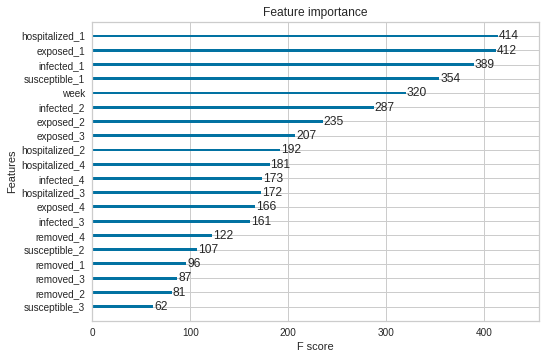

In [43]:
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(visualizer._Booster, max_num_features=20)
pyplot.show()

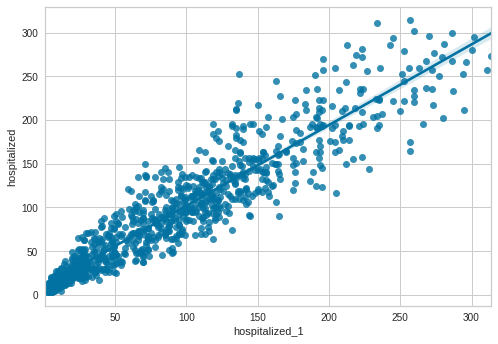

In [36]:
sns.regplot(x=X_train['hospitalized_1'][:1000], y=y_train[:1000]);
